In [1]:
#packages we need
using DifferentialEquations
using Plots 
using CSV
using Distributions
using Random
using DataFrames
using JLD2
using DelimitedFiles
using FileIO
using Sundials

In [48]:
#set up where CSV2Julia is
locationOfCSV2Julia="csv2model-multiscale.py"

#identify the three CSV sheets that describe the model
reactionsFile="reactions.csv"
parametersFile="parameters.csv"
rateLawsFile="rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile, "odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

inline
Running CSV2JuliaDiffEq with parameters hard-coded into the CSV file, if this is not correct, re-run with the 5th argument set to 'scan' or 'param'
Opening rateLaws.csv as rate law file
Opening parameters.csv as parameters file
Opening reactions.csv as reactions file


Process(`python3 csv2model-multiscale.py reactions.csv parameters.csv rateLaws.csv odeApoptosis.jl`, ProcessExited(0))

In [3]:
include("fixSpecies.jl")
fixSpecies("odeApoptosis.jl","odeApoptosisFixed.jl",1)
odeFile=include("odeApoptosisFixed.jl")
include("variableNames.jl")

59-element Vector{String}:
 "L"
 "R"
 "L_R"
 "DISC"
 "flip"
 "flip_DISC"
 "pC8"
 "DISC_pC8"
 "C8"
 "BAR"
 "BAR_C8"
 "pC3"
 "pC3_C8"
 ⋮
 "ASmac"
 "cCytoC"
 "Apaf"
 "Apaf_cCytoC"
 "ApafStar"
 "Procasp9"
 "Apop"
 "Apop_pC3"
 "cSmac"
 "Apop_XIAP"
 "cSmac_XIAP"
 "Bcl2t"

In [4]:
## Files and variables required to solve
p=1
maxTimeSS=100000.0
maxTimeTC=144*60.0
params=1

1

In [5]:
global f=ODEFunction(odeFile,syms=Symbol.(syms))

(::ODEFunction{true, SciMLBase.FullSpecialize, typeof(odeApoptosis!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) (generic function with 1 method)

In [6]:
## Bcl2t values:

# WT  = 277
# 1.5 = 415.5
# 2.0 = 554
# 2.5 = 692.5
# 3.0 = 831
# 3.5 = 969.5

# replace xxx with value for copy number

function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("L"),syms)]=0
   y0[findfirst(isequal("R"),syms)]=1000
   y0[findfirst(isequal("flip"),syms)]=2000
   y0[findfirst(isequal("pC8"),syms)]=10000
   y0[findfirst(isequal("BAR"),syms)]=1000
   y0[findfirst(isequal("pC3"),syms)]=10000
   y0[findfirst(isequal("pC6"),syms)]=10000
   y0[findfirst(isequal("XIAP"),syms)]=100000
   y0[findfirst(isequal("PARP"),syms)]=1000000
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Bcl2c"),syms)]=20000
   y0[findfirst(isequal("Bax"),syms)]=80000
   y0[findfirst(isequal("Bcl2"),syms)]=30000
   y0[findfirst(isequal("Mito"),syms)]=500000
   y0[findfirst(isequal("mCytoC"),syms)]=500000
   y0[findfirst(isequal("mSMac"),syms)]=100000
   y0[findfirst(isequal("Apaf"),syms)]=100000
   y0[findfirst(isequal("Procasp9"),syms)]=100000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=277
    return y0
end

initConditionsApop (generic function with 1 method)

### Steady state

In [7]:
function genSSconds(Bcl2,mut)
    y0=zeros(length(syms))
    y0=initConditionsApop(y0,syms)
    y0[findfirst(isequal("L"),syms)]=0
    y0[findfirst(isequal("Bcl2t"),syms)]=277*Bcl2

    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-5,reltol=1e-3, maxiters=1e10)
    solss=solve(prob, Rosenbrock23(), saveat=maxTimeSS/1000)

    #dynamic phase, use SS solution as initial conditions
    y0_ss=vec(convert(Array, solss[:,end]))    
    y0_ss[findfirst(isequal("L"),syms)]=1

    # save y0 as csv
    writedlm("SS_conds/"*mut_folder*"/steady_state_"*mut*".csv", y0_ss, ',')
    println("steady state conditions for "*mut*" saved")
end

genSSconds (generic function with 1 method)

In [9]:
#find cleaved parp
speciesToPlot="CPARP"
#find total PARP
denominator=["PARP","PARP_C3","CPARP"]
CPARPIndex=findfirst(isequal(speciesToPlot),syms)
denominatorIndexes=Array{Int64}(undef,length(denominator))
for i in 1:length(denominator)
    thisIndex=findfirst(isequal(denominator[i]),syms)
    denominatorIndexes[i]=convert(Int64,thisIndex)
end

In [26]:
## no multi-threading version

function solveCell(i)    
        
        y0_init = vec(readdlm("SS_conds/Bcl2_mutations/steady_state_"*string(i)*".csv"))
        prob=ODEProblem(f,y0_init,(0.0,maxTimeTC),abstol=1e-5,reltol=1e-3, maxiters=1e10)
        sol=solve(prob, Rosenbrock23(), saveat=1.0, progress = true)
        
        println(string(i)*" complete")
        return(sol)
end

solveCell (generic function with 1 method)

In [11]:
#now we'll actually solve the models

# Bcl2 x1.5 = Bcl2InhValue=0.666667

function solveSingle(mut)
            ## import init conditions
            y0_init = vec(readdlm("/"*mut_folder*"/steady_state_"*mut*".csv"))
 
            prob=ODEProblem(f,y0_init,(0.0,maxTimeTC),abstol=1e-5,reltol=1e-3,maxiters=1e10)
            sol=solve(prob,Rosenbrock23(),saveat=1.0,progress = true)
                  
            save("solutions/cell_"*mut*".jld2", "solution", sol)    
            return(sol)
end

solveSingle (generic function with 1 method)

In [12]:
function T2D_single(sol,mut)
        cParray=zeros(1,Int(maxTimeTC)+1)
        #sol = load("solutions/cell_"*string(mut)*".jld2", "solution")
        thisNumerator=sol[CPARPIndex,:] #cPARP
        thisDenominatorTCs=sol[denominatorIndexes,:]
        thisDenominator=sum(thisDenominatorTCs,dims=1) #other PARP species
        parpPercentage=thisNumerator./thisDenominator'
        return(parpPercentage)
end

T2D_single (generic function with 1 method)

In [13]:
muts=[1.0,1.5]

2-element Vector{Float64}:
 1.0
 1.5

In [14]:
function solvePlusT2D(mut_values)
    T2D_list=[]
    for i in muts
        sol = solveCell(i)
        PARPpc = T2D_single(sol,i)
        push!(T2D_list, PARPpc)
    end
    return(T2D_list)
end

solvePlusT2D (generic function with 1 method)

In [15]:
solPARPs = solvePlusT2D(muts)

1.0 complete
1.5 complete


2-element Vector{Any}:
 [0.0; 5.3212176328288025e-12; … ; 0.5576984971404451; 0.5577003112751368;;]
 [0.0; 5.3212176328283614e-12; … ; 0.535288482955306; 0.5352911649045119;;]

### plot single

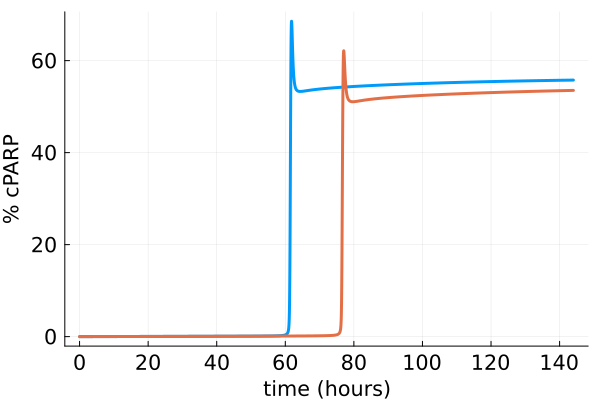

In [16]:
plot(solPARPs[1].*100,label="WT",linewidth=3, legend=false)
plot!(solPARPs[2].*100,label="Bcl2 x1.5",linewidth=3, legend=false)
s=string.(collect(0:20:150))
plot!(xticks = (0:(60*20):(60*150),s),xlabel="time (hours)",ylabel="% cPARP",fmt = :png,    
      xtickfontsize=14,
      ytickfontsize=14,
      xguidefontsize=14,
      yguidefontsize=14)

### Bcl2 mutations up to x100

In [7]:
mut_folder="Bcl2_mutations"

"Bcl2_mutations"

In [8]:
mkpath("starting_conds/"*mut_folder*"/")
mkpath("SS_conds/"*mut_folder*"/")
mkpath("solutions/"*mut_folder*"/")

"solutions/Bcl2_mutations"

In [17]:
Bcl2_muts = [1, 1.5, 2, 5, 10, 50, 100]

7-element Vector{Float64}:
   1.0
   1.5
   2.0
   5.0
  10.0
  50.0
 100.0

In [18]:
function calcT2D(sol, i)
    cParray=zeros(1,Int(maxTimeTC)+1)
    thisNumerator=sol[CPARPIndex,:] #cPARP
    thisDenominatorTCs=sol[denominatorIndexes,:]
    thisDenominator=sum(thisDenominatorTCs,dims=1) #other PARP species
    parpPercentage=thisNumerator./thisDenominator'
    cParray=[cParray;parpPercentage']
    if cParray[end] > 0.01
        T2Death = findfirst(x->x>0.01, cParray)            
        T2D_t = T2Death[2]
    else
        T2D_t = maxTimeTC
    end
        T2D_df = DataFrame(Mut="cell_"*string(i), T2D=T2D_t)
    return(T2D_df)
end

calcT2D (generic function with 1 method)

In [24]:
T2D_res = DataFrame(Mut=Any[],T2D=Float64[])
for i in Bcl2_muts
    sol = solveCell(i)
    T2Ddf = calcT2D(sol, i)
    T2D_res = append!(T2D_res, T2Ddf)
end

1.0 complete
1.5 complete
2.0 complete
5.0 complete
10.0 complete
50.0 complete
100.0 complete


In [44]:
T2D_res = sort!(T2D_res, :T2D, rev=true)

,Mut,T2D
,Any,Float64
1,cell_50.0,8640.0
2,cell_100.0,8640.0
3,cell_10.0,8640.0
4,cell_5.0,6152.0
5,cell_2.0,4974.0
6,cell_1.5,4556.0
7,cell_1.0,3648.0


In [27]:
using StatsPlots

In [28]:
cA=palette(:seaborn_colorblind)

In [46]:
y = ["x100","x50","x10","x5","x2","x1.5","WT"]

7-element Vector{String}:
 "x100"
 "x50"
 "x10"
 "x5"
 "x2"
 "x1.5"
 "WT"

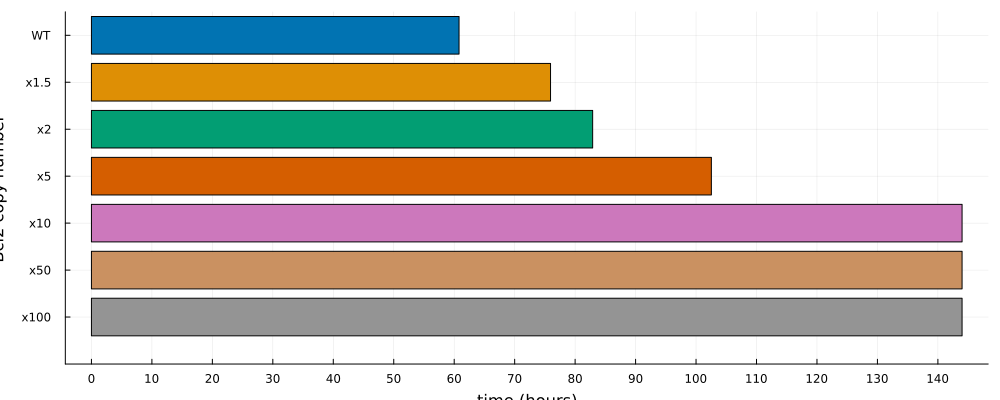

In [47]:
bar(T2D_res[:,2], orientation = :horizontal, size=(1000,400),legend=false,
                fillcolor=[cA[8],cA[6],cA[5],cA[4],cA[3],cA[2],cA[1],],
            yticks = (1:7, y), ylabel="Bcl2 copy number", ylim=(0,7.5))
s=string.(collect(0:10:140))
plot!(xticks = (0:(60*10):(60*140),s),xlabel="time (hours)",fmt = :png)

In [18]:
function runSim(first_cell, last_cell, Bcl2)
    Threads.@threads for i in first_cell:last_cell
        solveCell(i, Bcl2)
    end
end

runSim (generic function with 1 method)

In [19]:
runSim(first_cell, last_cell, 1)

solving cell: 5
solving cell: 18
solving cell: 13
solving cell: 17
solving cell: 10
solving cell: 7
solving cell: 2
solving cell: 9
solving cell: 12
solving cell: 16
solving cell: 8
solving cell: 11
solving cell: 15
solving cell: 14
solving cell: 1
solving cell: 19
solving cell: 20
solving cell: 6
solving cell: 3
solving cell: 4
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
steady state solved
final solution completed
final solution completed
final solution completed
final solution completed
final solution completed
final solution completed
final solution completed
final solution completed
final solution completed
final solution completed
final solution comp

In [10]:
function T2D(mut_folder)
    T2D_array = zeros(1, last_cell)
    for i in first_cell:last_cell
        if isfile("solutions/"*mut_folder*"/cell_"*string(i)*".jld2") == true
        cParray=zeros(1,Int(maxTimeTC)+1)
        sol = load("solutions/"*mut_folder*"/cell_"*string(i)*".jld2", "solution")
        thisNumerator=sol[varIndex,:] #cPARP
        thisDenominatorTCs=sol[denominatorIndexes,:]
        thisDenominator=sum(thisDenominatorTCs,dims=1) #other PARP species
        parpPercentage=thisNumerator./thisDenominator'
        cParray=[cParray;parpPercentage']
        T2Death = findfirst(x->x>0.01, cParray)
        T2D_array[i] = Float64(T2Death[2])
        else
            continue
        end
    end
    T2D_array_df = DataFrame(T2D_array', :auto)
    return(T2D_array_df)
end

T2D (generic function with 1 method)

In [18]:
function res_mod(res,mut)
    rowNumberList=rownumber.(eachrow(res))
    res.Cell_id="cell_".*string.(rowNumberList)
    rename!(res, :x1 => mut)
    sort!(res, [mut], rev=true)
    return(res)
end

res_mod (generic function with 1 method)

In [20]:
WT_T2D_mod = res_mod(WT_T2D, "WT")
Bcl2mut_T2D_mod = res_mod(Bcl2mut_T2D, "Bcl2mut");

In [37]:
#plotly()
CPARPIndex=findfirst(isequal("CPARP"),syms)

#plotVar=plot(legend=false,foreground_color_subplot=:white,title="all cells cparp percentage")
plotVar=Plots.plot(title="all cells cparp percentage WT")
for i in 1:10
    sol = load("solutions/test/cell_"*string(i)*".jld2", "solution")

    #calculate cleaved parp as a percentage of total and store in the array.
    thisNumerator=sol[CPARPIndex,:] #cPARP
    thisDenominatorTCs=sol[denominatorIndexes,:]
    thisDenominator=sum(thisDenominatorTCs,dims=1) #other PARP species
    parpPercentage=thisNumerator./thisDenominator'
    plot!(plotVar,parpPercentage.*100,label="cell: "*string(i),legend=false,
    xticks=(0:1000:8000))
end

┌ Warning: some parameters could not be resolved for type ODEFunction{true,Main.#odeFile,LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Vector{Symbol},Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing}; reconstructing
└ @ JLD2 /home/richard/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:451
┌ Warning: some parameters could not be resolved for type ODEFunction{true,Main.#odeFile,LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Vector{Symbol},Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing}; reconstructing
└ @ JLD2 /home/richard/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:451
┌ Warning: some parameters could not be resolved for type ODEFunction{true,Main.#odeFile,LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Vector{Symbol},Nothing,typeof(SciMLBase.

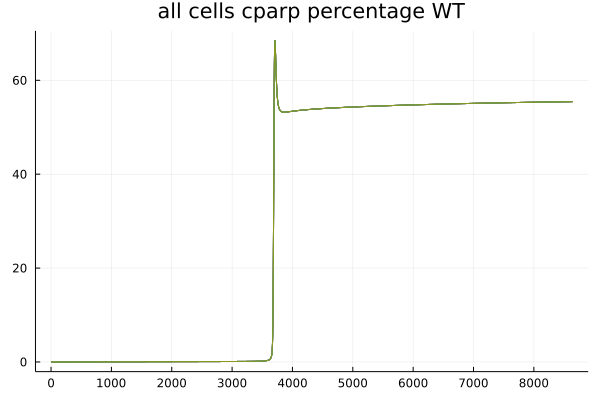

In [38]:
display(plotVar)

## Plot multiple

In [73]:
first_cell=1
last_cell=1500

1500

In [71]:
### Get T2D times

function getT2Dtimes(mut_folder)
    T2D_times_df = DataFrame(Cell=[], T2D=Int64[])

    for i in first_cell:last_cell
        if isfile("T2D_res/T2D_res_"*mut_folder*"/cell_"*string(i)*"_res.csv") == true
            T2D_times = DataFrame(CSV.File("T2D_res/T2D_res_"*mut_folder*"/cell_"*string(i)*"_res.csv", header=true))
            append!(T2D_times_df, T2D_times)
        else
            continue
        end
    end
    return(T2D_times_df)
end

getT2Dtimes (generic function with 1 method)

In [74]:
WT_res = getT2Dtimes("WT")
rename!(WT_res,:T2D => :WT)

Row,Cell,WT
,Any,Int64
1,cell_1,2622
2,cell_2,2838
3,cell_3,4072
4,cell_4,4098
5,cell_5,2733
6,cell_6,4530
7,cell_7,6564
8,cell_8,2959
9,cell_9,1907


In [75]:
Bcl2_mut_res = getT2Dtimes("Bcl2_mut")
rename!(Bcl2_mut_res,:T2D => :Bcl2_mut)

Row,Cell,Bcl2_mut
,Any,Int64
1,cell_1,3106
2,cell_2,3407
3,cell_3,5259
4,cell_4,7613
5,cell_5,3240
6,cell_6,6080
7,cell_7,3677
8,cell_8,3558
9,cell_9,2207


In [76]:
WT_res_mod = filter(:Cell => in(Bcl2_mut_res.Cell), WT_res)

Row,Cell,WT
,Any,Int64
1,cell_1,2622
2,cell_2,2838
3,cell_3,4072
4,cell_4,4098
5,cell_5,2733
6,cell_6,4530
7,cell_7,6564
8,cell_8,2959
9,cell_9,1907


In [2]:
WT_res_mod = DataFrame(CSV.File("WT_res_mod.csv"))
Bcl2mut_res_mod = DataFrame(CSV.File("Bcl2_res_mod.csv"));

In [77]:
WT_Bcl2_res = innerjoin(WT_res_mod, Bcl2_mut_res, on = :Cell)

Row,Cell,WT,Bcl2_mut
,Any,Int64,Int64
1,cell_1,2622,3106
2,cell_2,2838,3407
3,cell_3,4072,5259
4,cell_4,4098,7613
5,cell_5,2733,3240
6,cell_6,4530,6080
7,cell_7,6564,3677
8,cell_8,2959,3558
9,cell_9,1907,2207


In [78]:
WT_Bcl2_res = sort!(WT_Bcl2_res, [:WT], rev=true)

Row,Cell,WT,Bcl2_mut
,Any,Int64,Int64
1,cell_7,6564,3677
2,cell_1402,5704,8622
3,cell_1189,5653,8526
4,cell_1169,5648,8498
5,cell_949,5647,8603
6,cell_438,5646,8571
7,cell_1267,5630,8422
8,cell_837,5627,8536
9,cell_808,5607,8373


In [79]:
WT_Bcl2_res = WT_Bcl2_res[(WT_Bcl2_res.Cell .!= "cell_4"), :]

Row,Cell,WT,Bcl2_mut
,Any,Int64,Int64
1,cell_7,6564,3677
2,cell_1402,5704,8622
3,cell_1189,5653,8526
4,cell_1169,5648,8498
5,cell_949,5647,8603
6,cell_438,5646,8571
7,cell_1267,5630,8422
8,cell_837,5627,8536
9,cell_808,5607,8373


In [12]:
show(WT_Bcl2_res, allrows=true)

707×3 DataFrame
 Row │ Cell       WT     Bcl2_mut 
     │ Any        Int64  Int64    
─────┼────────────────────────────
   1 │ cell_7      6564      3677
   2 │ cell_949    5647      8603
   3 │ cell_438    5646      8571
   4 │ cell_837    5627      8536
   5 │ cell_808    5607      8373
   6 │ cell_411    5592      8439
   7 │ cell_30     5567      8408
   8 │ cell_890    5561      8331
   9 │ cell_706    5536      8198
  10 │ cell_82     5534      8316
  11 │ cell_41     5447      8004
  12 │ cell_860    5447      7961
  13 │ cell_829    5429      7905
  14 │ cell_589    5424      7910
  15 │ cell_348    5421      7942
  16 │ cell_613    5389      7811
  17 │ cell_358    5388      7830
  18 │ cell_690    5383      7869
  19 │ cell_305    5374      7801
  20 │ cell_110    5372      7768
  21 │ cell_805    5350      7753
  22 │ cell_447    5327      7687
  23 │ cell_266    5305      7632
  24 │ cell_74     5302      7592
  25 │ cell_281    5277      7564
  26 │ cell_297    5273      

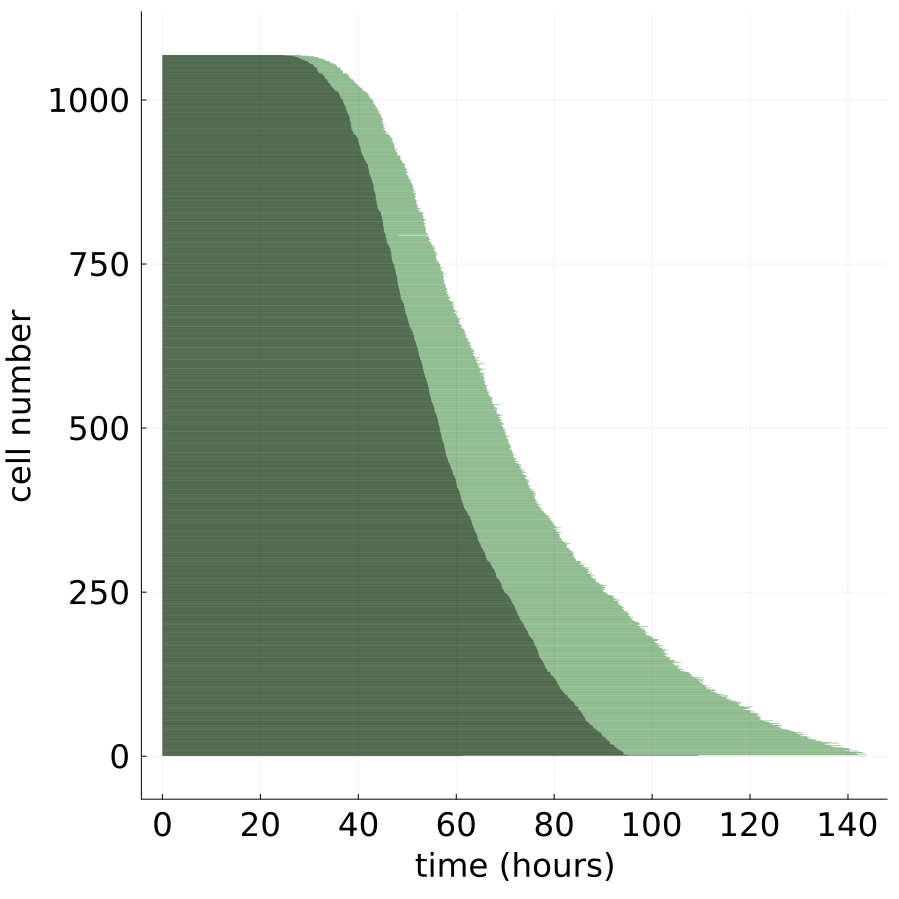

In [80]:
bar(WT_Bcl2_res.Bcl2_mut, orientation=:h, size=(900,900), linewidth = 0, color=:green, alpha=0.5, legend=false)
bar!(WT_Bcl2_res.WT, orientation=:h, size=(900,900), linewidth = 0, color=:black, alpha=0.5, legend=false)
s=string.(collect(0:20:140))
plot!(xticks = (0:(60*20):(60*140),s),xlabel="time (hours)",ylabel="cell number",fmt = :png,
        xtickfontsize=22,
        ytickfontsize=22,
        xguidefontsize=22,
        yguidefontsize=22)

In [81]:
using StatsPlots

In [82]:
pyplot()

Plots.PyPlotBackend()

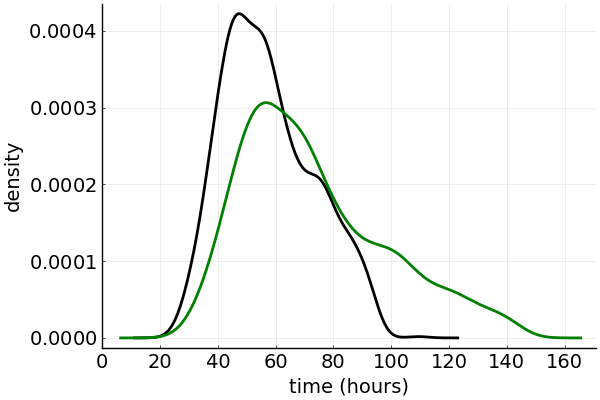

In [84]:
density(WT_Bcl2_res[!, :WT], color=:black, label="WT", linewidth=2, legend=false)
density!(WT_Bcl2_res[!, :Bcl2_mut], label="Bcl2 x1.5", color=:green, linewidth=2, legend=false)
s=string.(collect(0:20:170))
plot!(xticks = (0:(60*20):(60*170),s),xlabel="time (hours)",ylabel="density",fmt = :png,
        xtickfontsize=14,
        ytickfontsize=14,
        xguidefontsize=14,
        yguidefontsize=14)